# Some ideas to explore


* check performance with sliding window on/off
* check performance with binary vs float labels
* check performance with different ticker price windows and corresponding feature windows

Other idea for catagorical label generation
* predict on x intervals for movement in the next y interval of time. e.g. using intervals of 6 hours predict the movement in the next 12-24 hours 


# Check that GPU is listed for tensorflow

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13108204899530850248
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3831431168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10796929710522430238
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:02:00.0, compute capability: 5.0"
]


# Load Ticker Data

In [3]:
import pandas as pd

In [4]:
eth_ticker_raw = pd.read_csv("data/ticker_data/USDT_ETH.csv",index_col=0)
btc_ticker_raw = pd.read_csv("data/ticker_data/USDT_BTC.csv",index_col=0)          

In [5]:
eth_ticker_raw[eth_ticker_raw.Timestamp == 1439014500]

,Close,Timestamp,High,Low,Open
0,1.75,1439014500,0.33,1.61,0.33


In [6]:
btc_ticker_raw[btc_ticker_raw.Timestamp == 1439014500]

,Close,Timestamp,High,Low,Open
48805,273.947811,1439014500,275.603572,273.947811,275.603572


In [7]:
btc_ticker_raw.head()

,Close,Timestamp,High,Low,Open
0,225.0,1424373000,0.33,225.0,0.33
1,225.0,1424373300,225.00,225.0,225.00
2,225.0,1424373600,225.00,225.0,225.00
3,225.0,1424373900,225.00,225.0,225.00
4,225.0,1424374200,225.00,225.0,225.00


In [8]:
# sync the times of the two dataframes

# Data Preparation

* align the btc and eth data
* write function that can create data point windows - 5 minutes, 20 minutes, 6 hours
* create features and outputs

## Align Data

In [9]:
ticker_data_merged = eth_ticker_raw.set_index("Timestamp")\
                .join(
                        btc_ticker_raw.set_index("Timestamp"),
                        on="Timestamp",
                        how="inner",
                        lsuffix="_eth",
                        rsuffix="_btc")

In [10]:
ticker_data_merged.head()

,Close_eth,High_eth,Low_eth,Open_eth,Close_btc,High_btc,Low_btc,Open_btc
Timestamp,,,,,,,,
1439014500,1.75,0.33,1.61,0.33,273.947811,275.603572,273.947811,275.603572
1439014800,1.85,1.85,1.85,1.85,273.905543,273.905543,273.626238,273.901814
1439015100,1.85,1.85,1.85,1.85,273.905543,273.905543,273.905543,273.905543
1439015400,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572
1439015700,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572


## Modify Time Spans

In [11]:
ticker_data_merged.dtypes

Close_eth    float64
High_eth     float64
Low_eth      float64
Open_eth     float64
Close_btc    float64
High_btc     float64
Low_btc      float64
Open_btc     float64
dtype: object

In [12]:
import numpy as np

# in minutes 
minutes = 10
data_point_bucket_size = str(minutes) + "T"

datetime = pd.to_datetime(ticker_data_merged.index,unit='s') 


agg_method = {'Close_eth': "last",
                "High_eth": np.max, 
                "Low_eth": np.min,
                "Open_eth": "first",
                "Close_btc": "last",
                "High_btc": np.max, 
                "Low_btc": np.min,
                "Open_btc": "first", 
                 }

ticker_data = ticker_data_merged.set_index(datetime)\
                                    .resample(data_point_bucket_size)\
                                    .agg(agg_method)

print("Shape of reshaped data: " + str(ticker_data.shape))
print("Shape of original data: " + str(ticker_data_merged.shape))

Shape of reshaped data: (150216, 8)
Shape of original data: (300430, 8)


In [13]:
ticker_data.head()

,Close_eth,High_eth,Low_eth,Open_eth,Close_btc,High_btc,Low_btc,Open_btc
Timestamp,,,,,,,,
2015-08-08 06:10:00,1.75,0.33,1.61,0.33,273.947811,275.603572,273.947811,275.603572
2015-08-08 06:20:00,1.85,1.85,1.85,1.85,273.905543,273.905543,273.626238,273.901814
2015-08-08 06:30:00,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572
2015-08-08 06:40:00,1.85,1.85,1.85,1.85,273.917572,273.917572,273.917572,273.917572
2015-08-08 06:50:00,1.71,1.71,1.71,1.71,274.155050,274.155050,274.155050,274.155050


## * Adding Sentiment information

From the research it looked like sentiments from 4-2 days ago yielded the best results.
* I need to consider different time intervals and how i will slide the data?

In [14]:
# how am I going to aggrigate the values?
# ratios?
# sums?
# exclude the guys who are close to 0?

## Construct % price change label

In [15]:
eth_close_percent_change = ticker_data.Close_btc.pct_change()
ticker_data["eth_close_percent_change"] = eth_close_percent_change

In [16]:
ticker_data.dtypes

Close_eth                   float64
High_eth                    float64
Low_eth                     float64
Open_eth                    float64
Close_btc                   float64
High_btc                    float64
Low_btc                     float64
Open_btc                    float64
eth_close_percent_change    float64
dtype: object

## * Construct Binary label to capture up or down movement between days

# specify the output
#close_ethb

In [17]:
nothing_changed = ticker_data.eth_close_percent_change.round(decimals=6) == 0
negative_change = ticker_data.eth_close_percent_change.round(decimals=6) < 0
positive_change = ticker_data.eth_close_percent_change.round(decimals=6) > 0



In [18]:
ticker_data["eth_close_movement"] = -9

ticker_data["eth_close_movement"][positive_change] = 1 
ticker_data["eth_close_movement"][nothing_changed] = 0
ticker_data["eth_close_movement"][negative_change] = -1

/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

In [19]:
ticker_data

,Close_eth,High_eth,Low_eth,Open_eth,Close_btc,High_btc,Low_btc,Open_btc,eth_close_percent_change,eth_close_movement
Timestamp,,,,,,,,,,
2015-08-08 06:10:00,1.750000,0.330000,1.610000,0.330000,273.947811,275.603572,273.947811,275.603572,NaN,-9
2015-08-08 06:20:00,1.850000,1.850000,1.850000,1.850000,273.905543,273.905543,273.626238,273.901814,-0.000154,-1
2015-08-08 06:30:00,1.850000,1.850000,1.850000,1.850000,273.917572,273.917572,273.917572,273.917572,0.000044,1
2015-08-08 06:40:00,1.850000,1.850000,1.850000,1.850000,273.917572,273.917572,273.917572,273.917572,0.000000,0
2015-08-08 06:50:00,1.710000,1.710000,1.710000,1.710000,274.155050,274.155050,274.155050,274.155050,0.000867,1
2015-08-08 07:00:00,1.710000,1.710000,1.710000,1.710000,274.155050,274.155050,274.155050,274.155050,0.000000,0
2015-08-08 07:10:00,0.500000,1.750000,0.500000,1.750000,273.874325,273.952246,273.874325,273.952246,-0.001024,-1
2015-08-08 07:20:00,1.850000,1.850000,0.500000,0.500000,273.879113,273.879113,273.874325,273.874325,0.000017,1
2015-08-08 07:30:00,1.850000,1.850000,1.850000,1.850000,273.879113,273.879113,273.879113,273.879113,0.000000,0


**Key**
* -1 went down
* 0 stayed the same
* 1 went up

# Construction of Features & Labels

The features I care about:
* eth closing
* btc closing
* eth closing 3 days ago
* eth closing 4 days ago
* btc closing 3 days ago
* btc closing 4 days ago
* sentiment for 3 days ago
* sentiment for 4 days ago

The ratio of features to labels will be 16. And 6 days worth of data needs to be read at a time. This is in line with the research on sentiment analysis. 

For example:
* If the 5 minute intervals are used then the number of features need to be +- 1728 (8640 minutes) and the vector size of the label will be 108 (540 minutes or 9 hours)

**Temporal Golden Rule 1:**
* Temporal order must be preserved. Your features can not be further in time then your labels. 

**NOTE** the above should be doubled as the btc and eth values will be in the input layer

In [14]:
data_point_window = 5
days = 6
feature_vector_size = 6*24*60/data_point_window
output_vector_size = feature_vector_size/16

output_vector_minutes_span = output_vector_size*5
output_vector_hour_span = output_vector_minutes_span/60

print("Number of days feature vector will cover: " + str(days))
print("Data Point Window Size: " + str(data_point_window) + " minutes")
print("Size of feature vector: " + str(feature_vector_size))
print()
print("Number of minutes output vector will cover: " + str(output_vector_minutes_span))
print("Number of hours output vector will cover: " + str(output_vector_hour_span))
print("Size of output vector: " + str(output_vector_size))


Number of days feature vector will cover: 6
Data Point Window Size: 5 minutes
Size of feature vector: 1728.0

Number of minutes output vector will cover: 540.0
Number of hours output vector will cover: 9.0
Size of output vector: 108.0


The following class was obtained from [the following blog](https://nicholastsmith.wordpress.com/2017/11/13/cryptocurrency-price-prediction-using-deep-learning-in-tensorflow/)

In [15]:
##QUESTION!!!!???? bias introduced in the label if there is overlap with the next training row?

import numpy as np
import pandas as pd
 
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            slide_windows_size = 1
            I = np.arange(M) + np.arange(A.shape[0] - M + slide_windows_size).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
            
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix



In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalization

df = ticker_data.copy()
time_stamps_index = df.index

original_df = ticker_data.copy()

columns = ["Close_eth","Close_btc"]

for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

 


In [17]:
df

,Close_eth,High_eth,Low_eth,Open_eth,Close_btc,High_btc,Low_btc,Open_btc
Timestamp,,,,,,,,
2015-08-08 06:10:00,0.001227,0.330000,1.610000,0.330000,0.004831,275.603572,273.947811,275.603572
2015-08-08 06:20:00,0.001297,1.850000,1.850000,1.850000,0.004829,273.905543,273.626238,273.901814
2015-08-08 06:30:00,0.001297,1.850000,1.850000,1.850000,0.004830,273.917572,273.917572,273.917572
2015-08-08 06:40:00,0.001297,1.850000,1.850000,1.850000,0.004830,273.917572,273.917572,273.917572
2015-08-08 06:50:00,0.001199,1.710000,1.710000,1.710000,0.004842,274.155050,274.155050,274.155050
2015-08-08 07:00:00,0.001199,1.710000,1.710000,1.710000,0.004842,274.155050,274.155050,274.155050
2015-08-08 07:10:00,0.000348,1.750000,0.500000,1.750000,0.004828,273.952246,273.874325,273.952246
2015-08-08 07:20:00,0.001297,1.850000,0.500000,0.500000,0.004828,273.879113,273.874325,273.874325
2015-08-08 07:30:00,0.001297,1.850000,1.850000,1.850000,0.004828,273.879113,273.879113,273.879113


In [18]:
#Features are input sample dimensions(channels)
A = np.array(df)[:,None,:]
original_A = np.array(original_df)[:,None,:]
time_stamps = np.array(time_stamps_index)[:,None,None]

##Make samples of temporal sequences of pricing data (channel)
#Number of past samples
NPS = 256

#Number of future samples
NFS = 1         

ps = PastSampler(NPS, NFS, sliding_window=True)

X, Y = ps.transform(A)
original_X, original_Y = ps.transform(original_A)

input_times, output_times = ps.transform(time_stamps)

In [19]:
## For market movement

#Features are input sample dimensions(channels)
A = np.array(df)[:,None,:]
original_A = np.array(original_df)[:,None,:]
time_stamps = np.array(time_stamps_index)[:,None,None]

##Make samples of temporal sequences of pricing data (channel)
#Number of past samples
NPS = 576 #(4 days)#144 #(24 hours)#10

#Number of future samples
NFS = 36 #(6 hours)#2

ps = PastSampler(NPS, NFS, sliding_window=True)

X, Y = ps.transform(A)
original_X, original_Y = ps.transform(original_A)

input_times, output_times = ps.transform(time_stamps)

In [20]:
print(input_times[0])
print("---")
print(output_times[0])

[['2015-08-08T06:10:00.000000000']
 ['2015-08-08T06:20:00.000000000']
 ['2015-08-08T06:30:00.000000000']
 ['2015-08-08T06:40:00.000000000']
 ['2015-08-08T06:50:00.000000000']
 ['2015-08-08T07:00:00.000000000']
 ['2015-08-08T07:10:00.000000000']
 ['2015-08-08T07:20:00.000000000']
 ['2015-08-08T07:30:00.000000000']
 ['2015-08-08T07:40:00.000000000']
 ['2015-08-08T07:50:00.000000000']
 ['2015-08-08T08:00:00.000000000']
 ['2015-08-08T08:10:00.000000000']
 ['2015-08-08T08:20:00.000000000']
 ['2015-08-08T08:30:00.000000000']
 ['2015-08-08T08:40:00.000000000']
 ['2015-08-08T08:50:00.000000000']
 ['2015-08-08T09:00:00.000000000']
 ['2015-08-08T09:10:00.000000000']
 ['2015-08-08T09:20:00.000000000']
 ['2015-08-08T09:30:00.000000000']
 ['2015-08-08T09:40:00.000000000']
 ['2015-08-08T09:50:00.000000000']
 ['2015-08-08T10:00:00.000000000']
 ['2015-08-08T10:10:00.000000000']
 ['2015-08-08T10:20:00.000000000']
 ['2015-08-08T10:30:00.000000000']
 ['2015-08-08T10:40:00.000000000']
 ['2015-08-08T10:50:

In [22]:
Y_closing_eth_price = Y[:,0,0]
#Y_market_movement = Y[:,0,9]
Y.shape

(149605, 36, 8)

In [ ]:
Y[:,0,0]

In [ ]:
Y[:,35,0]

In [ ]:
0.00082603/0.00062919

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
np.divide(Y[:,0,0],Y[:,35,0]) 

In [27]:
Y.shape

(149605, 36, 8)

In [41]:
np.average(np.divide(Y[0:100000,0,0],Y[0:100000,35,0]) < 1)

/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


0.47718

In [42]:
np.average(np.divide(Y[0:100000,0,0],Y[0:100000,35,0]) > 1)

/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


0.45573

In [96]:
r_1 = Y[0:100000,0,0]
r_2 = Y[0:100000,35,0]
r_3 = np.divide(r_1,r_2)

r_c_lt = r_3 < 1
r_c_gt = r_3 > 1


/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
np.average(r_3[r_c_lt])

0.9713363119724743

In [98]:
np.average(r_3[r_c_gt][1:7054])

1.0624381022928213

In [90]:
r_3[r_c][7053:7055]
# point 7055 has an inf for what ever reason.....

array([1.00766735,        inf])

In [54]:
np.average(r_3[r_c])

inf

In [44]:
np.divide(Y[0:100000,0,0],Y[0:100000,35,0])

/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.76170337, 0.76170337, 0.73662672, ..., 1.00539378, 0.99584584,
       0.99255389])

/home/jeroens/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


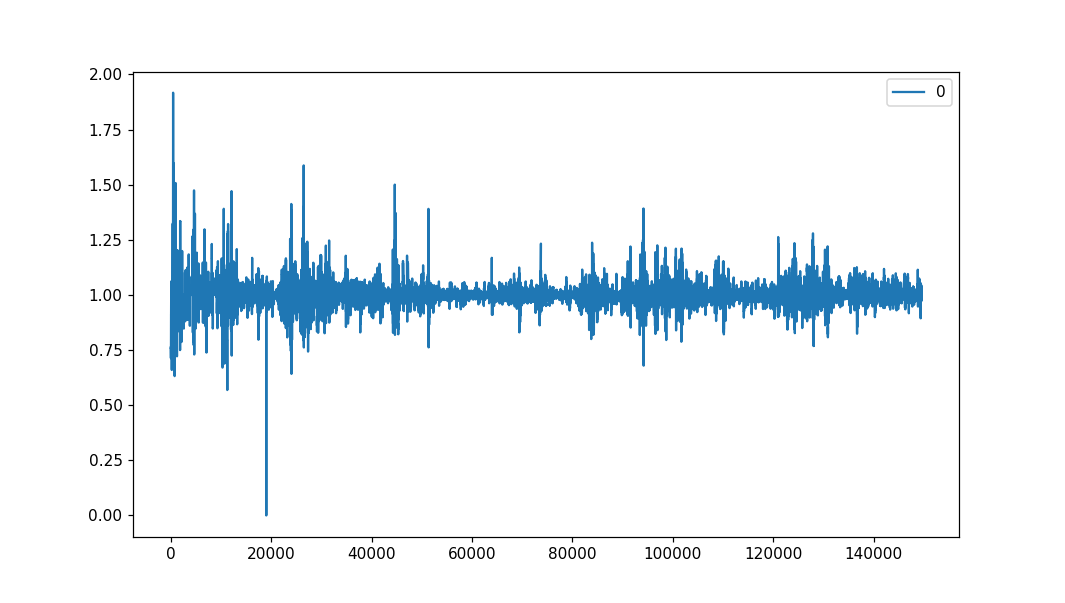

In [23]:
# 6 hours interval eth closing price % change
%matplotlib notebook
pd.DataFrame(np.divide(Y[:,0,0],Y[:,35,0])).plot(kind="line")

In [39]:

xx = Y[:,0,0] 

xxx = xx == 0
xx[xxx]

array([0.])

In [22]:
X.shape

(149605, 576, 8)

In [24]:
# labels for up/down behavior 
Y[:,0,0].shape

(149605,)

In [24]:
print("Shape of original_A" + str(original_A.shape))
print("Shape of time_stamps" + str(time_stamps.shape))
print("Shape of original_X" + str(original_X.shape))
print("Shape of original_Y" + str(original_Y.shape))
print("Shape of X" + str(X.shape))
print("Shape of Y" + str(Y.shape))

Shape of original_A(150216, 1, 10)
Shape of time_stamps(150216, 1, 1)
Shape of original_X(149945, 256, 10)
Shape of original_Y(149945, 16, 10)
Shape of X(149945, 256, 10)
Shape of Y(149945, 16, 10)


# Build CNN

In [28]:
# set sizes
training_size = int(0.7* X.shape[0])
remaining_size = X.shape[0] - training_size
test_size = int(remaining_size/2)
validation_size = int(remaining_size/2) 


#split training validation
training_features = X[:training_size,:]
training_labels = Y[:training_size,:]

# test set
test_features = X[training_size:,:]
test_labels = Y[training_size:,:]

# validation set
#validation_features = X[training_size:,:]
#validation_labels = Y[training_size:,:]


In [41]:
#build model
from keras import Sequential
from keras.layers import Conv1D, Dropout

epochs = 100
step_size = X.shape[1]
batch_size= 8
nb_features = X.shape[2]

In [40]:
# 2 layers
model = Sequential()

model.add(Conv1D(activation='relu', 
                 input_shape=(step_size, 
                            nb_features), 
                 strides=3, 
                 filters=8, 
                 kernel_size=20))

model.add(Dropout(0.5))
model.add(Conv1D(strides=4, 
                 filters=nb_features, 
                 kernel_size=16))

'''
# 3 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=8))
# 4 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=2))
'''
model.compile(loss='mse', optimizer='adam')

ValueError: Negative dimension size caused by subtracting 20 from 2 for 'conv1d_4/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,2,10], [1,20,10,8].

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 79, 8)             1608      
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 10)            1290      
Total params: 2,898
Trainable params: 2,898
Non-trainable params: 0
_________________________________________________________________


**Temporal Golden Rule 2:**
* Temporal Training Order: It can not train and predict on future data and then train and predict on past data.

In [33]:
trained_model = model.fit(training_features, 
          training_labels,
          verbose=1, 
          batch_size=batch_size,
          validation_data=(test_features,
                           test_labels), 
          epochs = epochs          
         )

Train on 104961 samples, validate on 44984 samples
Epoch 1/100
104961/104961 [==============================] - 37s 355us/step - loss: 325124.2903 - val_loss: 24574928.5939
Epoch 2/100
104961/104961 [==============================] - 31s 295us/step - loss: 319206.3967 - val_loss: 24511372.5927
Epoch 3/100
104961/104961 [==============================] - 35s 334us/step - loss: 313395.7965 - val_loss: 24448424.6937
Epoch 4/100
104961/104961 [==============================] - 38s 364us/step - loss: 307693.6730 - val_loss: 24385851.0978
Epoch 5/100
104961/104961 [==============================] - 34s 326us/step - loss: 302104.8042 - val_loss: 24323580.7076
Epoch 6/100
104961/104961 [==============================] - 35s 337us/step - loss: 296608.3416 - val_loss: 24261506.6296
Epoch 7/100
104961/104961 [==============================] - 36s 347us/step - loss: 291216.5676 - val_loss: 24199656.1998
Epoch 8/100
104961/104961 [==============================] - 34s 324us/step - loss: 285922.3568

KeyboardInterrupt: 